AI 期末作業 - DNN vs CNN 分類模型比較
------------------
此腳本將時間序列人流資料進行分類預測，
同時使用 DNN 和 CNN 兩種模型進行訓練與比較。

每個 ###### 註解區塊可作為 Jupyter Notebook 的獨立 cell


Cell 1: 匯入套件

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 設定隨機種子以確保結果可重現
torch.manual_seed(42)
np.random.seed(42)

Cell 2: 載入資料

In [2]:
df = pd.read_csv("../data/task1_dataset_kotae.csv")
print(f"資料總筆數: {len(df)}")
df.head()

資料總筆數: 111535175


,uid,d,t,x,y
0,0,0,1,79,86
1,0,0,2,79,86
2,0,0,8,77,86
3,0,0,9,77,86
4,0,0,19,81,89


Cell 3: 資料統計與分析

In [3]:
print(f"x 範圍: {df['x'].min()} ~ {df['x'].max()}")
print(f"y 範圍: {df['y'].min()} ~ {df['y'].max()}")
print(f"t 範圍: {df['t'].min()} ~ {df['t'].max()}")

# 計算各位置的人流統計
count_table = df.value_counts(['x', 'y', 't', 'd']).reset_index(name='number of people')
count_table_for_analyse = df.value_counts(['x', 'y']).reset_index(name='number of people')
count_table_for_analyse

x 範圍: 1 ~ 200
y 範圍: 1 ~ 200
t 範圍: 0 ~ 47


,x,y,number of people
0,135,77,359963
1,135,82,196083
2,134,77,176167
3,129,81,151722
4,135,78,140375
...,...,...,...
34027,122,165,1
34028,44,126,1
34029,200,168,1
34030,122,178,1


Cell 4: 選擇前三大人流地點

In [4]:
# 找出人口數前三多的地點
top_3_locations = count_table_for_analyse.nlargest(3, 'number of people')
print("人口數前三多的地點 (x, y):")
print(top_3_locations)
print("-" * 30)

# 從 count_table 中篩選這三個地點的資料
locations_to_find = top_3_locations[['x', 'y']]
result_df = pd.merge(count_table, locations_to_find, on=['x', 'y'], how='inner')
print(f"篩選後資料筆數: {len(result_df)}")
result_df

人口數前三多的地點 (x, y):
     x   y  number of people
0  135  77            359963
1  135  82            196083
2  134  77            176167
------------------------------
篩選後資料筆數: 10797


,x,y,t,d,number of people
0,135,77,36,68,301
1,135,77,36,66,297
2,135,77,37,68,296
3,135,77,36,54,295
4,135,77,36,26,295
...,...,...,...,...,...
10792,134,77,6,15,1
10793,134,77,6,8,1
10794,134,77,6,2,1
10795,134,77,5,56,1


Cell 5: Reshape 資料 - 將 t 轉為小時

In [5]:
# 1. 建立樞紐分析表
pivot_df = result_df.pivot_table(
    index=['x', 'y', 'd'], 
    columns='t', 
    values='number of people', 
    fill_value=0
)

# 2. 確保所有時間點 (0-47) 都存在
pivot_df = pivot_df.reindex(columns=np.arange(48), fill_value=0)

# 3. 將半小時資料合併為一小時 (Sum)
data_hourly = pivot_df.T.groupby(lambda t: t // 2).sum().T

print("資料轉換完成！")
print(f"資料維度 (樣本數, 24小時): {data_hourly.shape}")
data_hourly.head()

資料轉換完成！
資料維度 (樣本數, 24小時): (225, 24)


t           0     1     2     3     4     5     6      7      8      9   ...  \
x   y  d                                                                 ...   
134 77 0  26.0  22.0  17.0  19.0  15.0  22.0  46.0   60.0   86.0   97.0  ...   
       1  13.0  16.0  11.0   7.0  10.0  10.0  49.0   53.0   71.0   88.0  ...   
       2   9.0  13.0  12.0   4.0   7.0  14.0  62.0  161.0  177.0  152.0  ...   
       3  11.0  11.0   9.0   6.0  12.0  15.0  59.0  140.0  213.0  166.0  ...   
       4  15.0  11.0  11.0  15.0  15.0  18.0  78.0  128.0  198.0  172.0  ...   

t            14     15     16     17     18     19     20     21    22    23  
x   y  d                                                                      
134 77 0  151.0  134.0  140.0  129.0  112.0  107.0   74.0   67.0  57.0  41.0  
       1  118.0  116.0  110.0  108.0  107.0   84.0   72.0   40.0  35.0  22.0  
       2  118.0  132.0  136.0  192.0  202.0  133.0  119.0   81.0  60.0  28.0  
       3  142.0  151.0  170.0  203.0  212.0  152.0   97.0  112.0  52.0  38.0  
       4  138.0  144.0  156.0  193.0  181.0  160.0  119.0   99.0  48.0  39.0  

[5 rows x 24 columns]

Cell 6: 製作分類標籤

In [6]:
X_list = []
y_list = []

# 製作早上的資料 (0-7時) - Label 0
X_morning = data_hourly.loc[:, 0:7].values
y_morning = np.zeros(len(X_morning))
X_list.append(X_morning)
y_list.append(y_morning)

# 製作下午的資料 (8-15時) - Label 1
X_afternoon = data_hourly.loc[:, 8:15].values
y_afternoon = np.ones(len(X_afternoon))
X_list.append(X_afternoon)
y_list.append(y_afternoon)

# 製作晚上的資料 (16-23時) - Label 2
X_evening = data_hourly.loc[:, 16:23].values
y_evening = np.full(len(X_evening), 2)
X_list.append(X_evening)
y_list.append(y_evening)

# 合併所有資料
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print(f"特徵資料 X 形狀: {X.shape} (樣本數, 8小時人流)")
print(f"標籤資料 y 形狀: {y.shape} (對應的時段標籤)")
print(f"類別分布: 早上={np.sum(y==0)}, 下午={np.sum(y==1)}, 晚上={np.sum(y==2)}")


特徵資料 X 形狀: (675, 8) (樣本數, 8小時人流)
標籤資料 y 形狀: (675,) (對應的時段標籤)
類別分布: 早上=225, 下午=225, 晚上=225


Cell 7: 分割訓練集與測試集

In [7]:
# 切分資料：80% 訓練, 20% 測試
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# 轉換為 PyTorch Tensor
X_train = torch.FloatTensor(X_train_np)
X_test = torch.FloatTensor(X_test_np)
y_train = torch.LongTensor(y_train_np)
y_test = torch.LongTensor(y_test_np)

print(f"訓練集 Tensor 形狀: {X_train.shape}, {y_train.shape}")
print(f"測試集 Tensor 形狀: {X_test.shape}, {y_test.shape}")


訓練集 Tensor 形狀: torch.Size([540, 8]), torch.Size([540])
測試集 Tensor 形狀: torch.Size([135, 8]), torch.Size([135])


Cell 8: 定義 DNN 模型

In [8]:
class DNNClassifier(nn.Module):
    """
    深度神經網路 (DNN) 分類器
    架構: 輸入(8) -> 隱藏層1(64) -> 隱藏層2(32) -> 輸出(3)
    """
    def __init__(self, input_size=8, hidden1=64, hidden2=32, num_classes=3, dropout=0.2):
        super(DNNClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.layer2 = nn.Linear(hidden1, hidden2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.output = nn.Linear(hidden2, num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.output(x)
        return x

print("DNN 模型架構已定義")
dnn_model = DNNClassifier()
print(dnn_model)


DNN 模型架構已定義
DNNClassifier(
  (layer1): Linear(in_features=8, out_features=64, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (output): Linear(in_features=32, out_features=3, bias=True)
)


Cell 9: 定義 CNN 模型

In [9]:
class CNNClassifier(nn.Module):
    """
    卷積神經網路 (CNN) 分類器
    使用 1D 卷積處理時間序列資料
    架構: 輸入(1, 8) -> Conv1d -> Pool -> Conv1d -> FC -> 輸出(3)
    """
    def __init__(self, input_size=8, num_classes=3, dropout=0.2):
        super(CNNClassifier, self).__init__()
        
        # 第一層卷積: 1 通道 -> 32 通道, kernel_size=3
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)  # 8 -> 4
        
        # 第二層卷積: 32 通道 -> 64 通道, kernel_size=3
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)  # 4 -> 2
        
        # 全連接層
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 2, 32)  # 64 通道 * 2 長度
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(32, num_classes)
        
    def forward(self, x):
        # 輸入 x 的形狀: (batch_size, 8)
        # 需要轉換為 (batch_size, 1, 8) 以符合 Conv1d 的輸入要求
        x = x.unsqueeze(1)  # (batch_size, 1, 8)
        
        # 第一層卷積
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)  # (batch_size, 32, 4)
        
        # 第二層卷積
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)  # (batch_size, 64, 2)
        
        # 全連接層
        x = self.flatten(x)  # (batch_size, 128)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

print("CNN 模型架構已定義")
cnn_model = CNNClassifier()
print(cnn_model)

CNN 模型架構已定義
CNNClassifier(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=128, out_features=32, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
)


Cell 10: 定義通用訓練函數

In [10]:
def train_model(model, X_train, y_train, X_test, y_test, 
                epochs=50, batch_size=16, learning_rate=0.001, model_name="Model"):
    """
    通用模型訓練函數
    
    Args:
        model: PyTorch 模型
        X_train, y_train: 訓練資料
        X_test, y_test: 測試資料
        epochs: 訓練輪數
        batch_size: 批次大小
        learning_rate: 學習率
        model_name: 模型名稱（用於輸出）
    
    Returns:
        history: 訓練歷史紀錄
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    history = {
        'accuracy': [], 
        'loss': [], 
        'val_accuracy': [], 
        'val_loss': []
    }
    
    n_samples = X_train.shape[0]
    
    print(f"\n開始訓練 {model_name}...")
    
    for epoch in range(epochs):
        # --- 訓練階段 ---
        model.train()
        train_loss = 0.0
        correct_train = 0
        
        permutation = torch.randperm(n_samples)
        
        for i in range(0, n_samples, batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_x.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == batch_y).sum().item()
        
        avg_train_loss = train_loss / n_samples
        train_acc = correct_train / n_samples
        
        # --- 驗證階段 ---
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            v_loss = criterion(val_outputs, y_test)
            _, val_predicted = torch.max(val_outputs, 1)
            val_acc = (val_predicted == y_test).sum().item() / len(y_test)
            val_loss = v_loss.item()
        
        # 紀錄歷史數據
        history['loss'].append(avg_train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f}, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    print(f"{model_name} 訓練完成！")
    print(f"最終訓練準確率: {history['accuracy'][-1]:.4f}")
    print(f"最終驗證準確率: {history['val_accuracy'][-1]:.4f}")
    
    return history


Cell 11: 訓練 DNN 模型

In [11]:
# 初始化 DNN 模型
dnn_model = DNNClassifier()

# 訓練 DNN
dnn_history = train_model(
    model=dnn_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    epochs=50,
    batch_size=16,
    learning_rate=0.001,
    model_name="DNN"
)


開始訓練 DNN...
Epoch [10/50], Loss: 0.0442, Acc: 0.9796, Val Loss: 0.0454, Val Acc: 0.9778
Epoch [20/50], Loss: 0.0315, Acc: 0.9944, Val Loss: 0.0272, Val Acc: 0.9852
Epoch [30/50], Loss: 0.0219, Acc: 0.9870, Val Loss: 0.0443, Val Acc: 0.9778
Epoch [40/50], Loss: 0.0564, Acc: 0.9926, Val Loss: 0.0272, Val Acc: 0.9852
Epoch [50/50], Loss: 0.0144, Acc: 0.9944, Val Loss: 0.0258, Val Acc: 0.9852
DNN 訓練完成！
最終訓練準確率: 0.9944
最終驗證準確率: 0.9852


Cell 12: 訓練 CNN 模型

In [12]:
# 初始化 CNN 模型
cnn_model = CNNClassifier()

# 訓練 CNN
cnn_history = train_model(
    model=cnn_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    epochs=50,
    batch_size=16,
    learning_rate=0.001,
    model_name="CNN"
)


開始訓練 CNN...
Epoch [10/50], Loss: 0.0215, Acc: 0.9944, Val Loss: 0.0526, Val Acc: 0.9852
Epoch [20/50], Loss: 0.0105, Acc: 0.9963, Val Loss: 0.0421, Val Acc: 0.9852
Epoch [30/50], Loss: 0.0055, Acc: 0.9981, Val Loss: 0.0416, Val Acc: 0.9852
Epoch [40/50], Loss: 0.0041, Acc: 1.0000, Val Loss: 0.0452, Val Acc: 0.9852
Epoch [50/50], Loss: 0.0032, Acc: 1.0000, Val Loss: 0.0487, Val Acc: 0.9852
CNN 訓練完成！
最終訓練準確率: 1.0000
最終驗證準確率: 0.9852


Cell 13: 視覺化比較 DNN vs CNN

c:\Users\88697\Desktop\school\人工智慧\term_term\114-1-ai-hw-submit\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35347 (\N{CJK UNIFIED IDEOGRAPH-8A13}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\88697\Desktop\school\人工智慧\term_term\114-1-ai-hw-submit\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32244 (\N{CJK UNIFIED IDEOGRAPH-7DF4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\88697\Desktop\school\人工智慧\term_term\114-1-ai-hw-submit\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36942 (\N{CJK UNIFIED IDEOGRAPH-904E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\88697\Desktop\school\人工智慧\term_term\114-1-ai-hw-submit\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31243 (\N{CJK UNIFIED IDEOGRAPH-7A0B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(

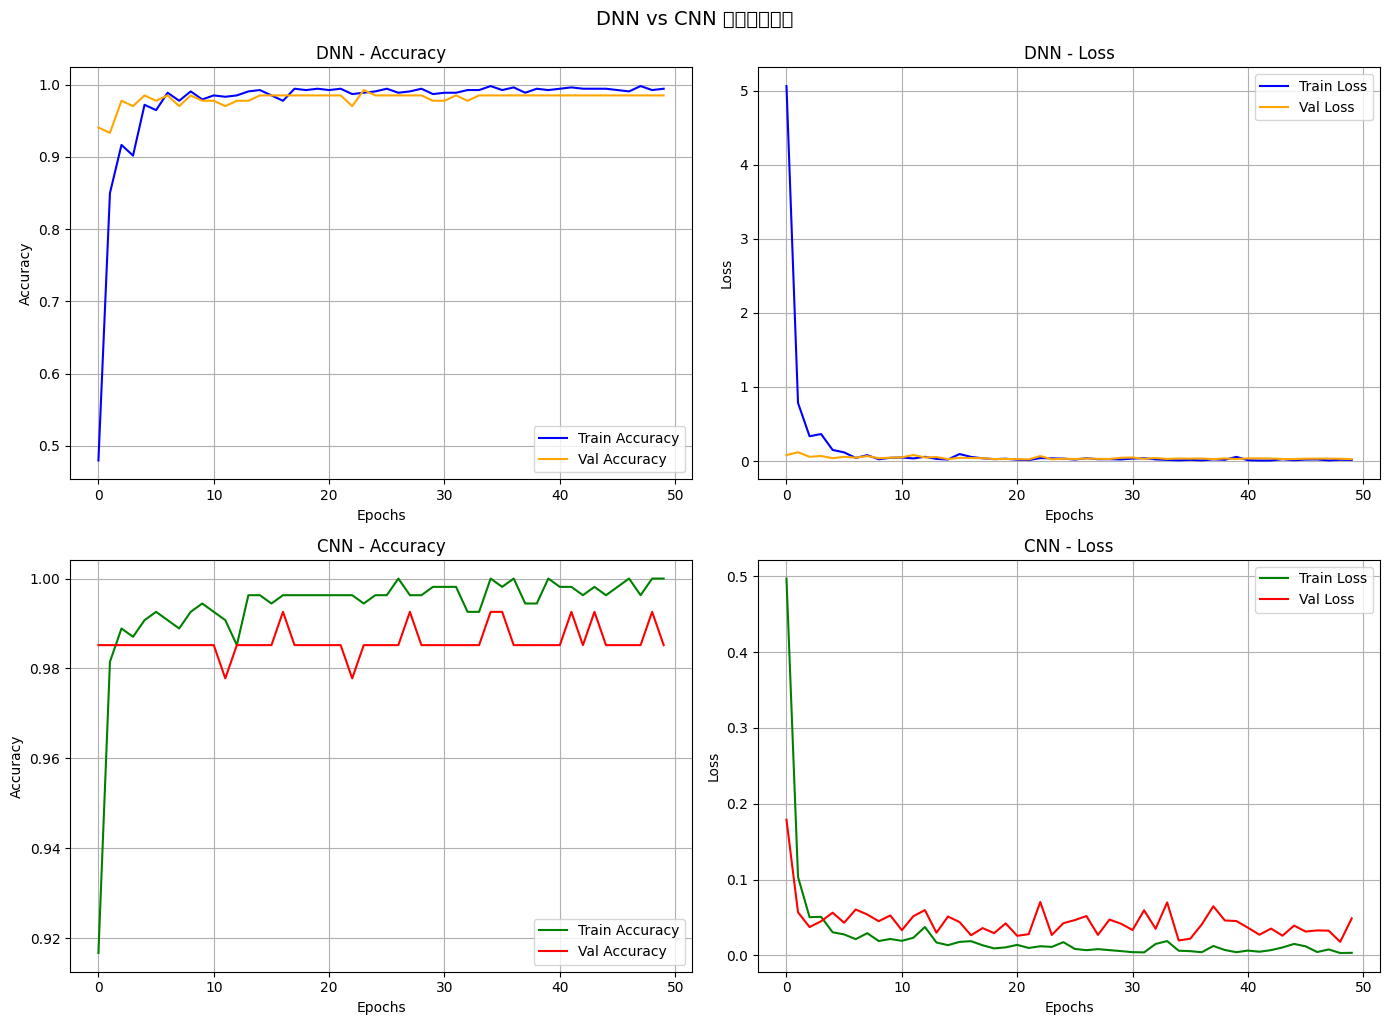

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# DNN 準確率
axes[0, 0].plot(dnn_history['accuracy'], label='Train Accuracy', color='blue')
axes[0, 0].plot(dnn_history['val_accuracy'], label='Val Accuracy', color='orange')
axes[0, 0].set_title('DNN - Accuracy')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# DNN Loss
axes[0, 1].plot(dnn_history['loss'], label='Train Loss', color='blue')
axes[0, 1].plot(dnn_history['val_loss'], label='Val Loss', color='orange')
axes[0, 1].set_title('DNN - Loss')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# CNN 準確率
axes[1, 0].plot(cnn_history['accuracy'], label='Train Accuracy', color='green')
axes[1, 0].plot(cnn_history['val_accuracy'], label='Val Accuracy', color='red')
axes[1, 0].set_title('CNN - Accuracy')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# CNN Loss
axes[1, 1].plot(cnn_history['loss'], label='Train Loss', color='green')
axes[1, 1].plot(cnn_history['val_loss'], label='Val Loss', color='red')
axes[1, 1].set_title('CNN - Loss')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.suptitle('DNN vs CNN 訓練過程比較', fontsize=14, y=1.02)
plt.show()


Cell 14: DNN vs CNN 直接對比圖

C:\Users\88697\AppData\Local\Temp\ipykernel_20236\738832861.py:21: UserWarning: Glyph 23565 (\N{CJK UNIFIED IDEOGRAPH-5C0D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\88697\AppData\Local\Temp\ipykernel_20236\738832861.py:21: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\88697\Desktop\school\人工智慧\term_term\114-1-ai-hw-submit\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23565 (\N{CJK UNIFIED IDEOGRAPH-5C0D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


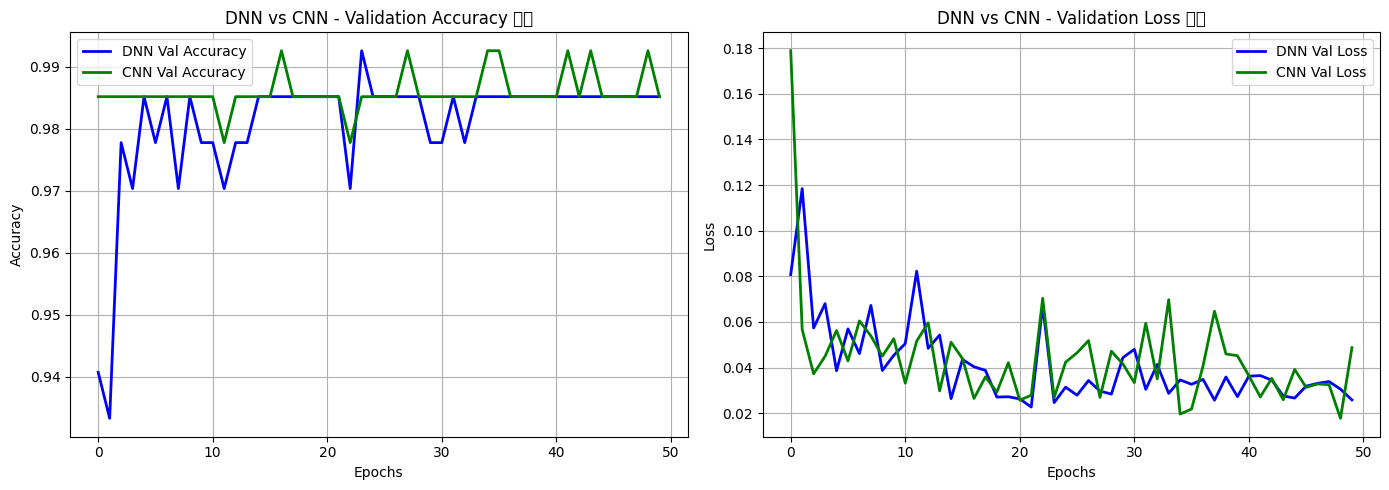

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 準確率對比
axes[0].plot(dnn_history['val_accuracy'], label='DNN Val Accuracy', color='blue', linewidth=2)
axes[0].plot(cnn_history['val_accuracy'], label='CNN Val Accuracy', color='green', linewidth=2)
axes[0].set_title('DNN vs CNN - Validation Accuracy 對比')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss 對比
axes[1].plot(dnn_history['val_loss'], label='DNN Val Loss', color='blue', linewidth=2)
axes[1].plot(cnn_history['val_loss'], label='CNN Val Loss', color='green', linewidth=2)
axes[1].set_title('DNN vs CNN - Validation Loss 對比')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


Cell 15: 模型效能總結

In [15]:
print("=" * 60)
print("模型效能總結")
print("=" * 60)

dnn_final_acc = dnn_history['val_accuracy'][-1]
cnn_final_acc = cnn_history['val_accuracy'][-1]
dnn_final_loss = dnn_history['val_loss'][-1]
cnn_final_loss = cnn_history['val_loss'][-1]

print(f"\n{'模型':<10} {'訓練準確率':<15} {'驗證準確率':<15} {'驗證 Loss':<15}")
print("-" * 60)
print(f"{'DNN':<10} {dnn_history['accuracy'][-1]:<15.4f} {dnn_final_acc:<15.4f} {dnn_final_loss:<15.4f}")
print(f"{'CNN':<10} {cnn_history['accuracy'][-1]:<15.4f} {cnn_final_acc:<15.4f} {cnn_final_loss:<15.4f}")

print("\n" + "=" * 60)
if cnn_final_acc > dnn_final_acc:
    print(f"結論: CNN 模型表現較佳，驗證準確率高出 {(cnn_final_acc - dnn_final_acc)*100:.2f}%")
elif dnn_final_acc > cnn_final_acc:
    print(f"結論: DNN 模型表現較佳，驗證準確率高出 {(dnn_final_acc - cnn_final_acc)*100:.2f}%")
else:
    print("結論: DNN 和 CNN 模型表現相當")
print("=" * 60)


模型效能總結

模型         訓練準確率           驗證準確率           驗證 Loss        
------------------------------------------------------------
DNN        0.9944          0.9852          0.0258         
CNN        1.0000          0.9852          0.0487         

結論: DNN 和 CNN 模型表現相當


Cell 16: 儲存模型

In [16]:
import os

save_dir = '../models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"已建立資料夾: {save_dir}")

# 儲存 DNN 模型
dnn_path = os.path.join(save_dir, 'dnn_time_classifier.pth')
torch.save(dnn_model.state_dict(), dnn_path)
print(f"DNN 模型已儲存至: {dnn_path}")

# 儲存 CNN 模型
cnn_path = os.path.join(save_dir, 'cnn_time_classifier.pth')
torch.save(cnn_model.state_dict(), cnn_path)
print(f"CNN 模型已儲存至: {cnn_path}")


DNN 模型已儲存至: ../models\dnn_time_classifier.pth
CNN 模型已儲存至: ../models\cnn_time_classifier.pth


Cell 17: 載入模型並進行推論測試

In [17]:
# 載入 DNN 模型
loaded_dnn = DNNClassifier()
loaded_dnn.load_state_dict(torch.load(dnn_path, weights_only=True))
loaded_dnn.eval()

# 載入 CNN 模型
loaded_cnn = CNNClassifier()
loaded_cnn.load_state_dict(torch.load(cnn_path, weights_only=True))
loaded_cnn.eval()

# 進行推論測試
with torch.no_grad():
    # 使用測試集進行推論
    dnn_preds = loaded_dnn(X_test)
    cnn_preds = loaded_cnn(X_test)
    
    _, dnn_predicted = torch.max(dnn_preds, 1)
    _, cnn_predicted = torch.max(cnn_preds, 1)
    
    dnn_test_acc = (dnn_predicted == y_test).sum().item() / len(y_test)
    cnn_test_acc = (cnn_predicted == y_test).sum().item() / len(y_test)

print("模型載入成功！")
print(f"DNN 測試準確率: {dnn_test_acc:.4f}")
print(f"CNN 測試準確率: {cnn_test_acc:.4f}")

模型載入成功！
DNN 測試準確率: 0.9852
CNN 測試準確率: 0.9852


Cell 18: (額外) 不同參數實驗 - 層數/神經元數比較


開始進行 DNN 不同架構參數實驗

訓練 DNN (32-16)...

開始訓練 DNN (32-16)...
Epoch [10/50], Loss: 0.1890, Acc: 0.9333, Val Loss: 0.0797, Val Acc: 0.9630
Epoch [20/50], Loss: 0.0914, Acc: 0.9722, Val Loss: 0.0450, Val Acc: 0.9778
Epoch [30/50], Loss: 0.0687, Acc: 0.9741, Val Loss: 0.0410, Val Acc: 0.9778
Epoch [40/50], Loss: 0.0314, Acc: 0.9889, Val Loss: 0.0384, Val Acc: 0.9778
Epoch [50/50], Loss: 0.0322, Acc: 0.9889, Val Loss: 0.0625, Val Acc: 0.9704
DNN (32-16) 訓練完成！
最終訓練準確率: 0.9889
最終驗證準確率: 0.9704

訓練 DNN (64-32)...

開始訓練 DNN (64-32)...
Epoch [10/50], Loss: 0.0606, Acc: 0.9778, Val Loss: 0.0868, Val Acc: 0.9704
Epoch [20/50], Loss: 0.0350, Acc: 0.9852, Val Loss: 0.0465, Val Acc: 0.9704
Epoch [30/50], Loss: 0.0433, Acc: 0.9926, Val Loss: 0.0309, Val Acc: 0.9852
Epoch [40/50], Loss: 0.0267, Acc: 0.9926, Val Loss: 0.0262, Val Acc: 0.9852
Epoch [50/50], Loss: 0.0162, Acc: 0.9907, Val Loss: 0.0249, Val Acc: 0.9852
DNN (64-32) 訓練完成！
最終訓練準確率: 0.9907
最終驗證準確率: 0.9852

訓練 DNN (128-64)...

開始訓練 DNN (128-64)...

C:\Users\88697\AppData\Local\Temp\ipykernel_20236\1738138722.py:66: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\88697\AppData\Local\Temp\ipykernel_20236\1738138722.py:66: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\88697\AppData\Local\Temp\ipykernel_20236\1738138722.py:66: UserWarning: Glyph 26550 (\N{CJK UNIFIED IDEOGRAPH-67B6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\88697\AppData\Local\Temp\ipykernel_20236\1738138722.py:66: UserWarning: Glyph 27083 (\N{CJK UNIFIED IDEOGRAPH-69CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\88697\AppData\Local\Temp\ipykernel_20236\1738138722.py:66: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\88697\AppData\Local\Temp\ipykernel_20236\1738138722.py:66: UserWarning: Glyph 36611 (\

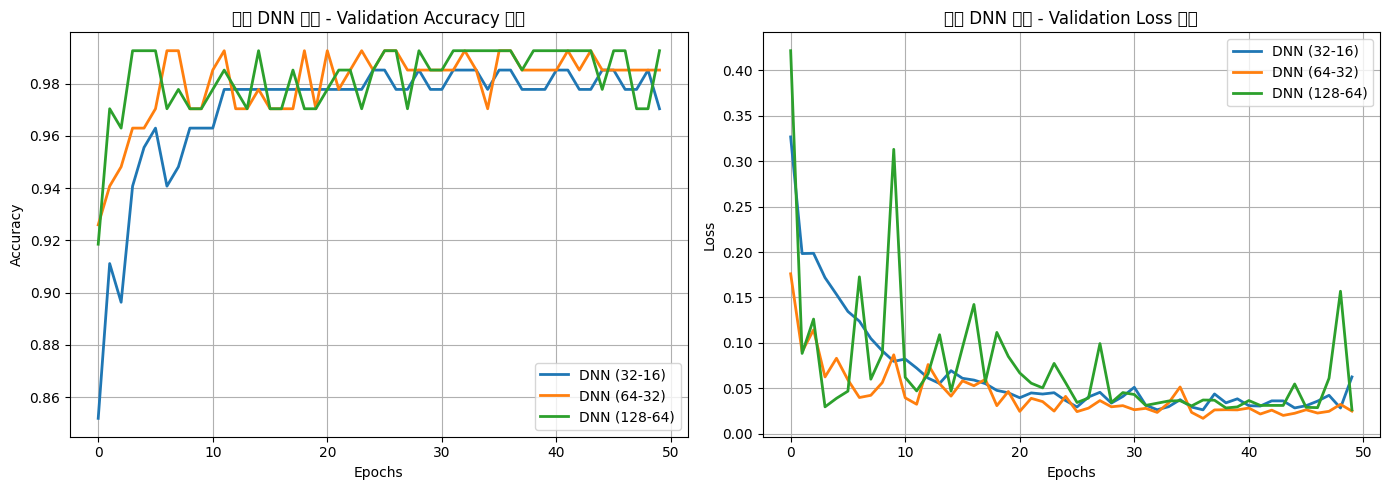


不同架構參數實驗結果總結

架構                   驗證準確率           驗證 Loss        
--------------------------------------------------
DNN (32-16)          0.9704          0.0625         
DNN (64-32)          0.9852          0.0249         
DNN (128-64)         0.9926          0.0263         

最佳架構: DNN (128-64) (驗證準確率: 0.9926)


In [18]:
# 這個 cell 可以用於參數討論，探討不同模型架構的影響

def experiment_dnn_architectures(X_train, y_train, X_test, y_test):
    """
    探討不同 DNN 架構對模型效能的影響
    """
    architectures = [
        {"hidden1": 32, "hidden2": 16, "name": "DNN (32-16)"},
        {"hidden1": 64, "hidden2": 32, "name": "DNN (64-32)"},
        {"hidden1": 128, "hidden2": 64, "name": "DNN (128-64)"},
    ]
    
    results = []
    
    for arch in architectures:
        print(f"\n訓練 {arch['name']}...")
        model = DNNClassifier(hidden1=arch['hidden1'], hidden2=arch['hidden2'])
        
        history = train_model(
            model=model,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            epochs=50,
            batch_size=16,
            learning_rate=0.001,
            model_name=arch['name']
        )
        
        results.append({
            'name': arch['name'],
            'final_val_acc': history['val_accuracy'][-1],
            'final_val_loss': history['val_loss'][-1],
            'history': history
        })
    
    return results

# 執行參數實驗
print("\n" + "=" * 60)
print("開始進行 DNN 不同架構參數實驗")
print("=" * 60)

arch_results = experiment_dnn_architectures(X_train, y_train, X_test, y_test)

# 繪製實驗結果
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for result in arch_results:
    axes[0].plot(result['history']['val_accuracy'], label=result['name'], linewidth=2)
    axes[1].plot(result['history']['val_loss'], label=result['name'], linewidth=2)

axes[0].set_title('不同 DNN 架構 - Validation Accuracy 比較')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('不同 DNN 架構 - Validation Loss 比較')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 輸出實驗結果總結
print("\n" + "=" * 60)
print("不同架構參數實驗結果總結")
print("=" * 60)
print(f"\n{'架構':<20} {'驗證準確率':<15} {'驗證 Loss':<15}")
print("-" * 50)
for result in arch_results:
    print(f"{result['name']:<20} {result['final_val_acc']:<15.4f} {result['final_val_loss']:<15.4f}")

best_arch = max(arch_results, key=lambda x: x['final_val_acc'])
print(f"\n最佳架構: {best_arch['name']} (驗證準確率: {best_arch['final_val_acc']:.4f})")
